In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as K

from SwinUNet import SwinUNet
from ConvUNet import ConvNeXTUNet
from dataset import DataGenerator

In [4]:
train_data = DataGenerator('/content/drive/MyDrive/image_segmentation_data/data/train', batch_size = 32)
val_data = DataGenerator('/content/drive/MyDrive/image_segmentation_data/data/val', batch_size = 32, predicting = True)

In [17]:
@tf.keras.saving.register_keras_serializable()
def dice_coef(y_true, y_pred):
  y_pred = tf.nn.softmax(y_pred)
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.01) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.01)

@tf.keras.saving.register_keras_serializable()
def dice_coef_multilabel(y_true, y_pred, numLabels=35):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice

In [18]:
swin_model = SwinUNet(128, 35, window_size = 4, patch_size=4, embed_dim = 96, depths = [2, 2, 2, 2], num_heads = [3, 3, 6, 6], attn_drop_rate = 0.3, proj_drop_rate = 0.3)
swin_model.compile(
    optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0001, learning_rate = 0.001),
    loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
    metrics= ['accuracy', dice_coef_multilabel],
)

In [19]:
swin_history = swin_model.fit(train_data, epochs = 15, validation_data = val_data)

Epoch 1/15
94/94 [==============================] - 207s 2s/step - loss: 0.4374 - accuracy: 0.5391 - dice_coef_multilabel: 0.2624 - val_loss: 0.3791 - val_accuracy: 0.6421 - val_dice_coef_multilabel: 0.2755
Epoch 2/15
94/94 [==============================] - 157s 2s/step - loss: 0.3068 - accuracy: 0.7119 - dice_coef_multilabel: 0.3096 - val_loss: 0.3170 - val_accuracy: 0.7125 - val_dice_coef_multilabel: 0.3109
Epoch 3/15
94/94 [==============================] - 157s 2s/step - loss: 0.2865 - accuracy: 0.7375 - dice_coef_multilabel: 0.3432 - val_loss: 0.2988 - val_accuracy: 0.7236 - val_dice_coef_multilabel: 0.3436
Epoch 4/15
94/94 [==============================] - 155s 2s/step - loss: 0.2773 - accuracy: 0.7515 - dice_coef_multilabel: 0.3620 - val_loss: 0.2882 - val_accuracy: 0.7394 - val_dice_coef_multilabel: 0.3588
Epoch 5/15
94/94 [==============================] - 155s 2s/step - loss: 0.2714 - accuracy: 0.7615 - dice_coef_multilabel: 0.3762 - val_loss: 0.2867 - val_accuracy: 0.7404 

In [22]:
os.makedirs('/content/drive/MyDrive/Models', exist_ok=True)
swin_model.save('/content/drive/MyDrive/Models/swinmodel.keras', save_format="keras")

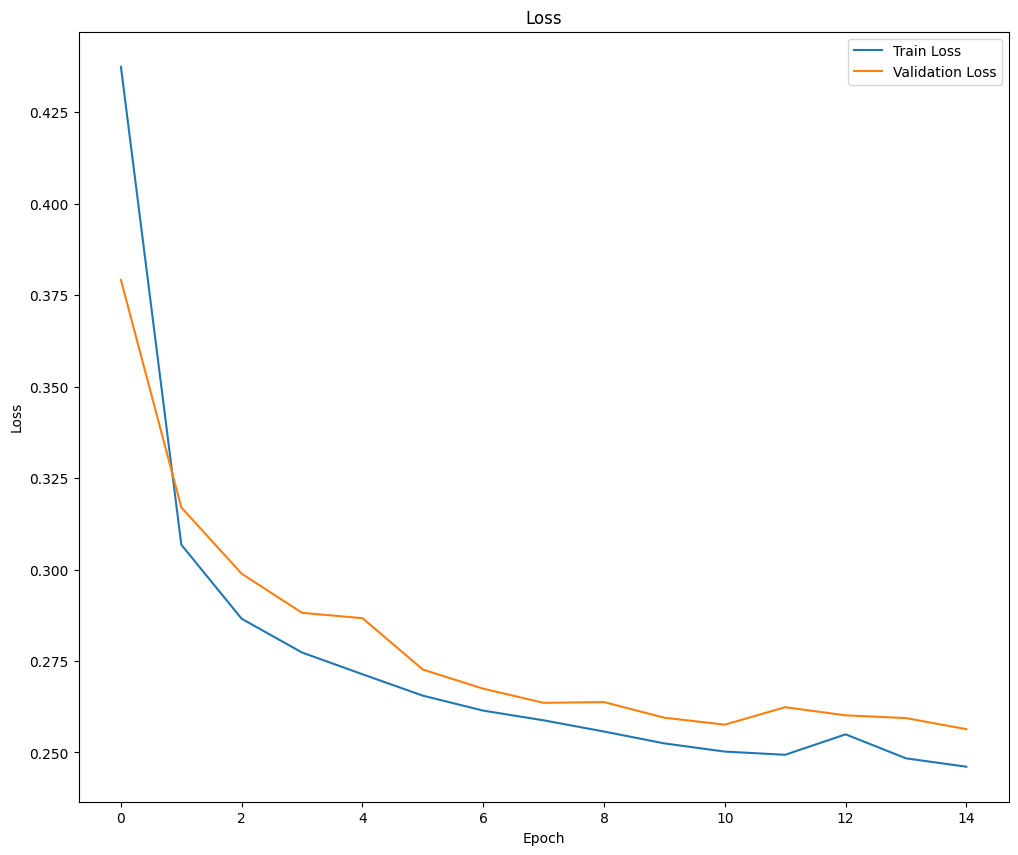

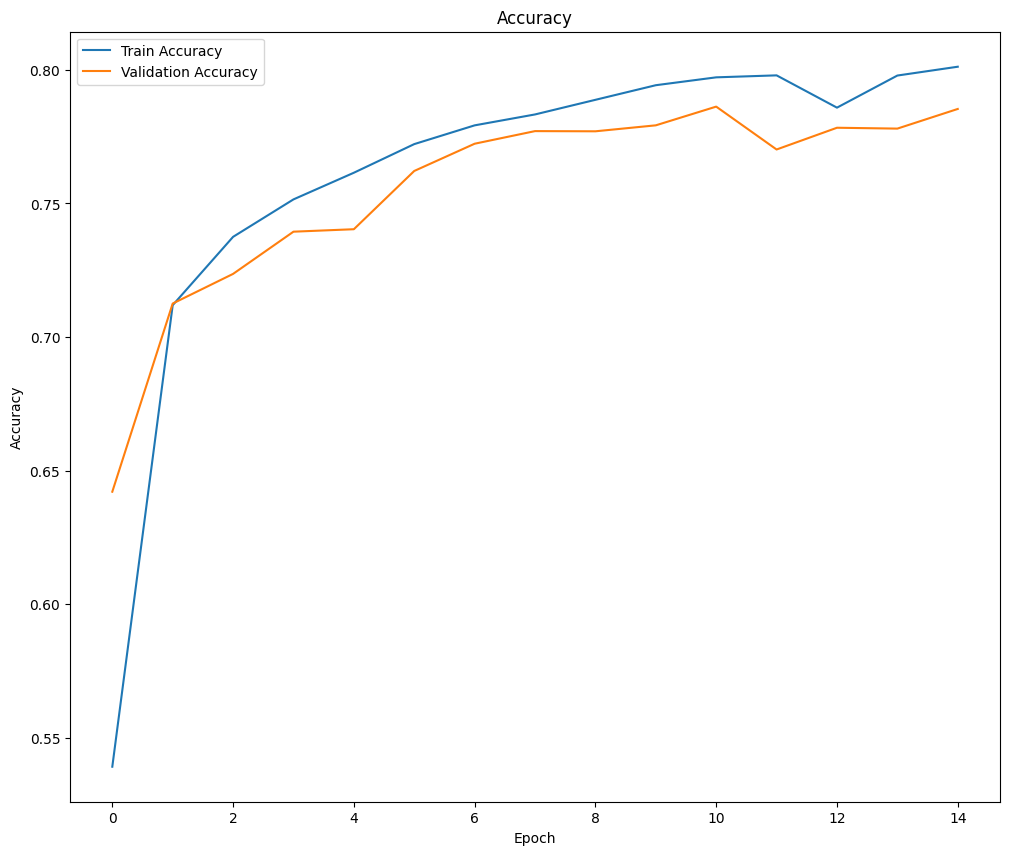

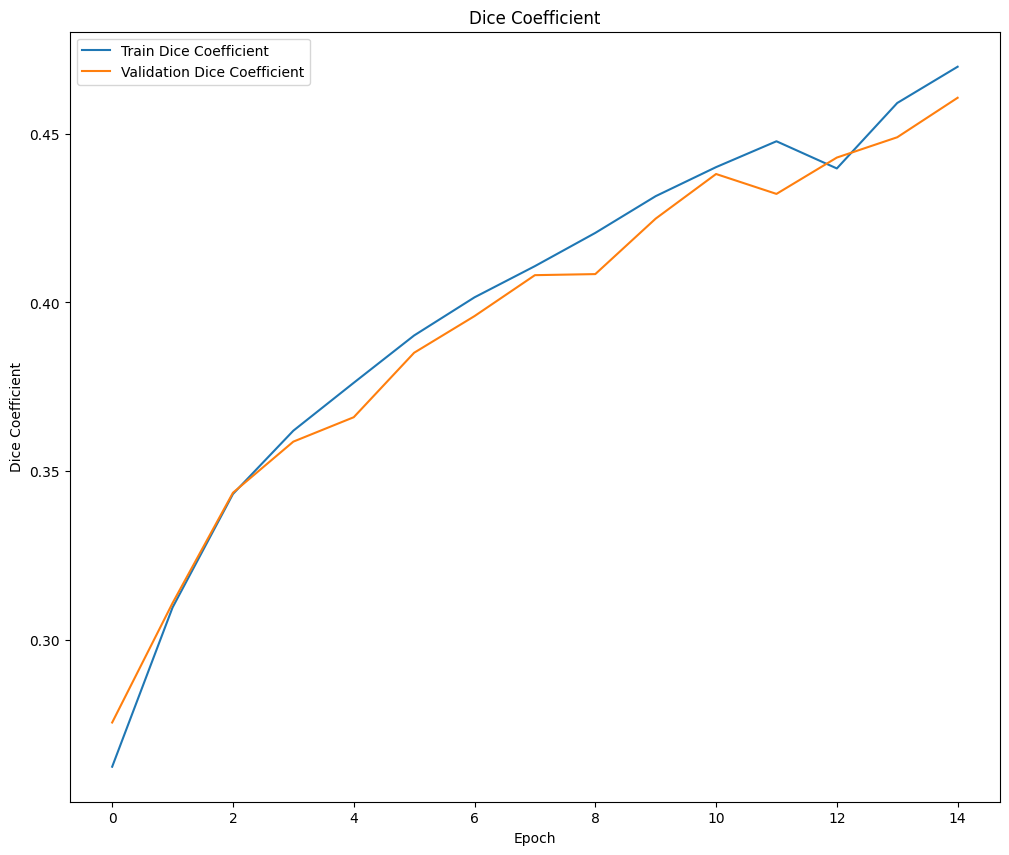

In [23]:
os.makedirs('/content/drive/MyDrive/plots/swinmodel', exist_ok=True)

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['loss'], label='Train Loss')
plt.plot(swin_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/plots/swinmodel/lossplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['accuracy'], label='Train Accuracy')
plt.plot(swin_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/plots/swinmodel/accuracyplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['dice_coef_multilabel'], label='Train Dice Coefficient')
plt.plot(swin_history.history['val_dice_coef_multilabel'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/plots/swinmodel/diceplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [27]:
conv_model = ConvNeXTUNet(128, 96, 35, [2, 2, 2, 2])
conv_model.compile(
    optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0001, learning_rate = 0.001),
    loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
    metrics= ['accuracy', dice_coef_multilabel],
)

In [28]:
conv_history = conv_model.fit(train_data, epochs = 15, validation_data = val_data)

Epoch 1/15
94/94 [==============================] - 204s 2s/step - loss: 0.4764 - accuracy: 0.4821 - dice_coef_multilabel: 0.2300 - val_loss: 0.5056 - val_accuracy: 0.5812 - val_dice_coef_multilabel: 0.2440
Epoch 2/15
94/94 [==============================] - 182s 2s/step - loss: 0.3197 - accuracy: 0.6898 - dice_coef_multilabel: 0.2911 - val_loss: 0.3469 - val_accuracy: 0.6458 - val_dice_coef_multilabel: 0.2916
Epoch 3/15
94/94 [==============================] - 173s 2s/step - loss: 0.2922 - accuracy: 0.7304 - dice_coef_multilabel: 0.3401 - val_loss: 0.3016 - val_accuracy: 0.7196 - val_dice_coef_multilabel: 0.3368
Epoch 4/15
94/94 [==============================] - 157s 2s/step - loss: 0.2808 - accuracy: 0.7471 - dice_coef_multilabel: 0.3649 - val_loss: 0.2948 - val_accuracy: 0.7350 - val_dice_coef_multilabel: 0.3542
Epoch 5/15
94/94 [==============================] - 158s 2s/step - loss: 0.2726 - accuracy: 0.7602 - dice_coef_multilabel: 0.3819 - val_loss: 0.2842 - val_accuracy: 0.7427 

In [31]:
conv_model.save('/content/drive/MyDrive/Models/conv_nextmodel.keras', save_format="keras")

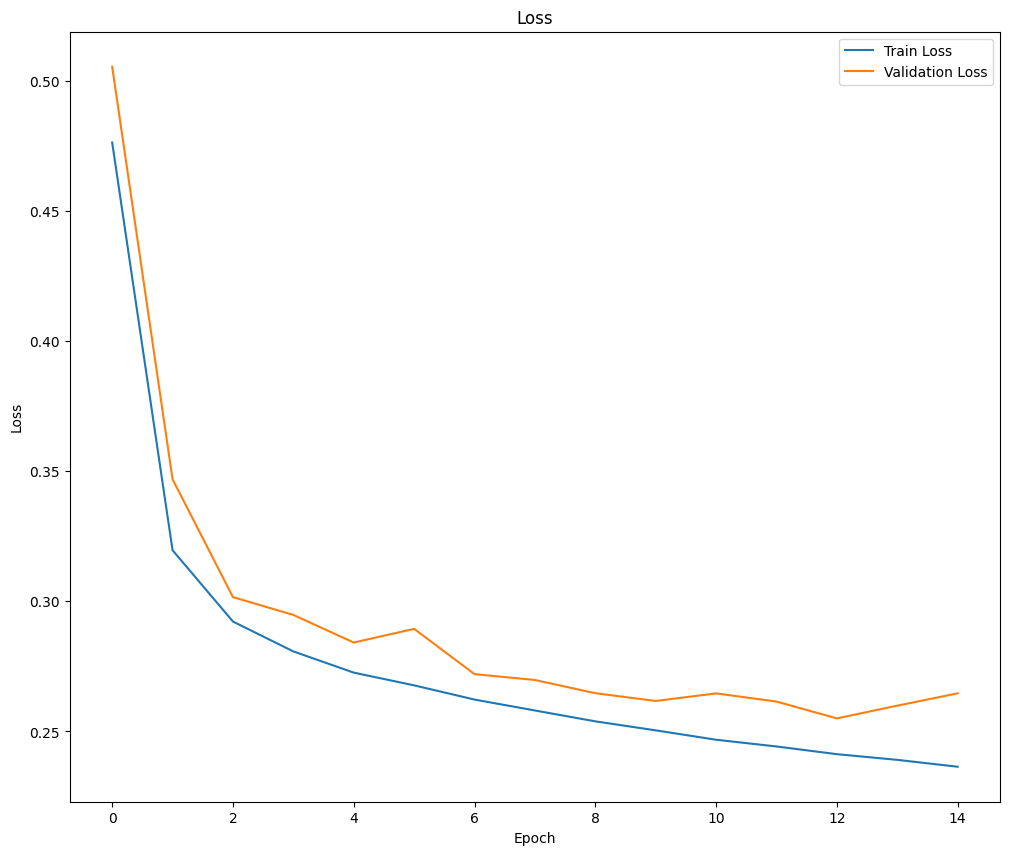

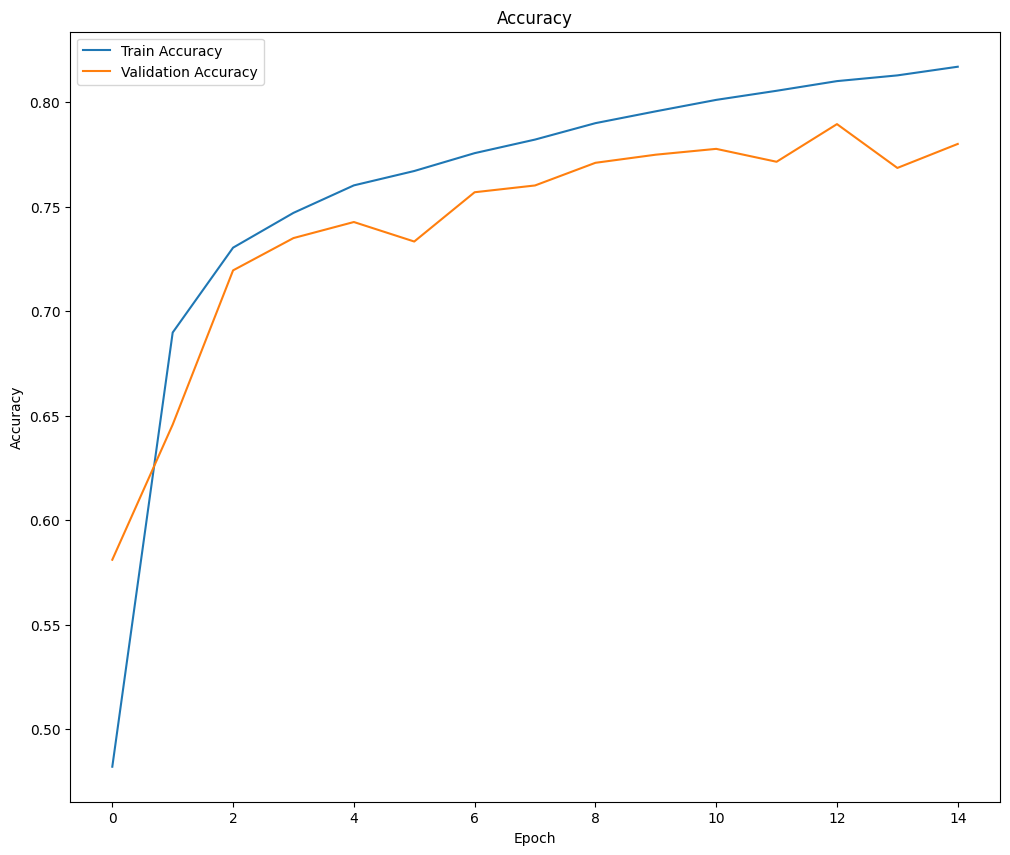

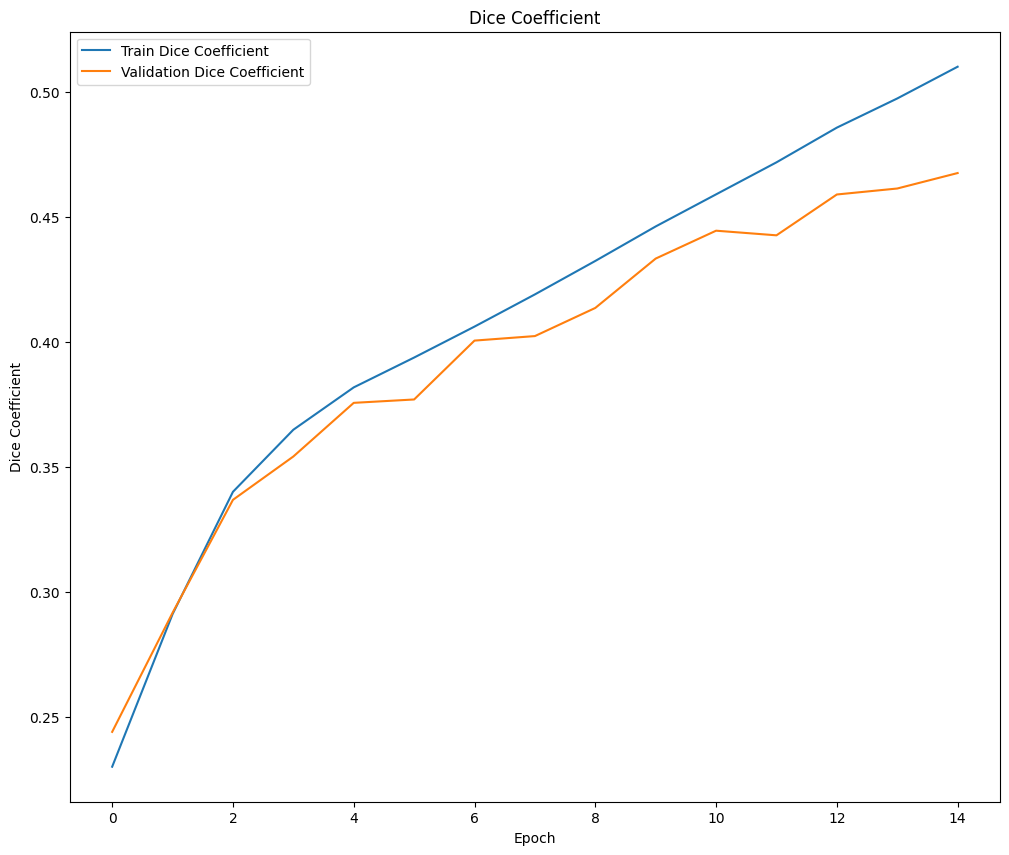

In [32]:
os.makedirs('/content/drive/MyDrive/plots/convmodel', exist_ok=True)

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['loss'], label='Train Loss')
plt.plot(conv_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/plots/convmodel/lossplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['accuracy'], label='Train Accuracy')
plt.plot(conv_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/plots/convmodel/accuracyplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['dice_coef_multilabel'], label='Train Dice Coefficient')
plt.plot(conv_history.history['val_dice_coef_multilabel'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/plots/convmodel/diceplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [33]:
for img, mask in val_data:
  true_mask = mask[:5]
  imgs = img[:5]
  break

prediction = swin_model.predict(tf.reshape(imgs, [5, 128, 128, 3]))
true_masks = np.argmax(true_mask, axis = -1)
predictions = np.argmax(prediction, axis = -1)

1/1 [==============================] - 0s 78ms/step


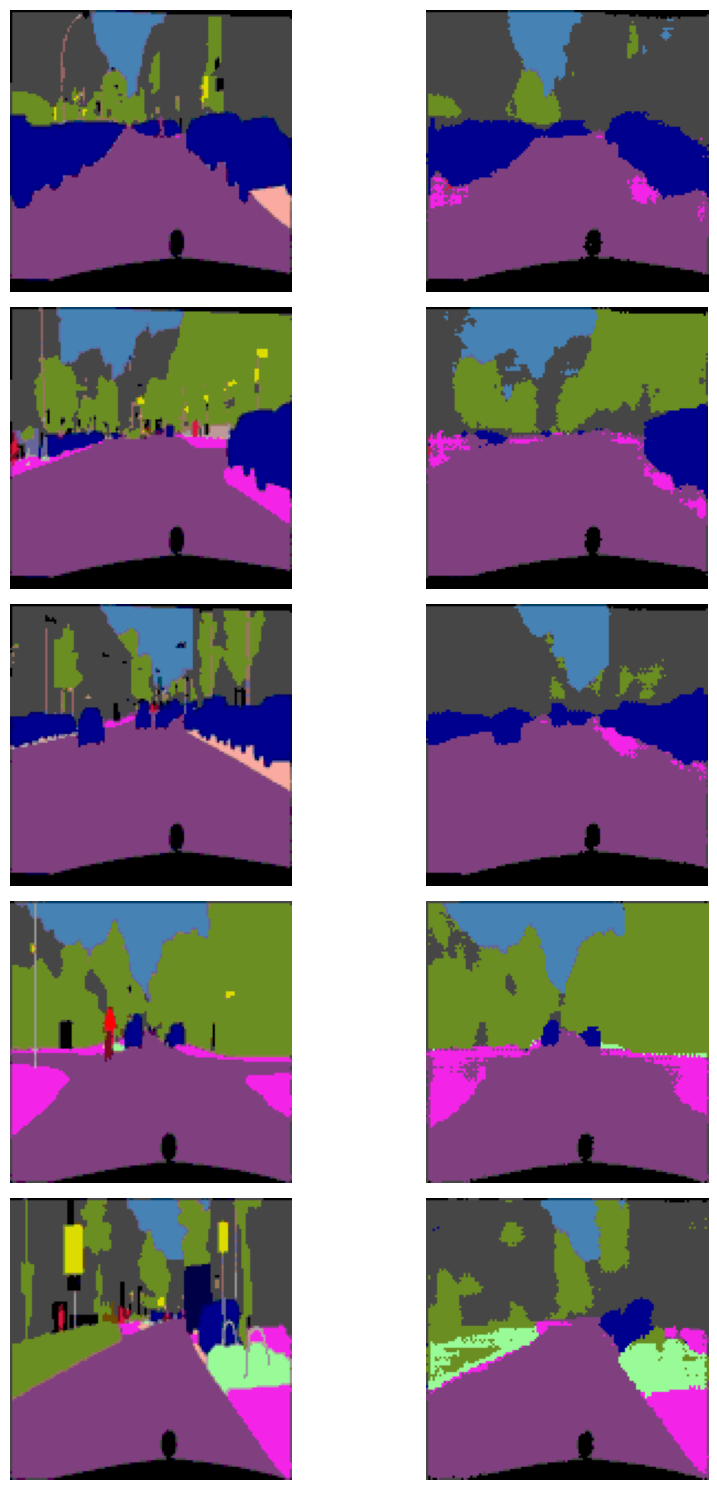

In [34]:
from labeldata import id_to_color
from PIL import Image

fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for index, (true_mask, prediction) in enumerate(zip(true_masks, predictions)):

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[0], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[0]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 0].imshow(temp)
    axes[index, 0].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([prediction.shape[0], prediction.shape[0], 3], dtype='uint8')
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[0]):
            temp[row, col, :] = id_to_color[prediction[row, col]]

    axes[index, 1].imshow(temp)
    axes[index, 1].axis('off')

plt.tight_layout()
plt.show()



In [35]:
for img, mask in val_data:
  true_mask = mask[:5]
  imgs = img[:5]
  break

prediction = conv_model.predict(tf.reshape(imgs, [5, 128, 128, 3]))
true_masks = np.argmax(true_mask, axis = -1)
predictions = np.argmax(prediction, axis = -1)

1/1 [==============================] - 1s 1s/step


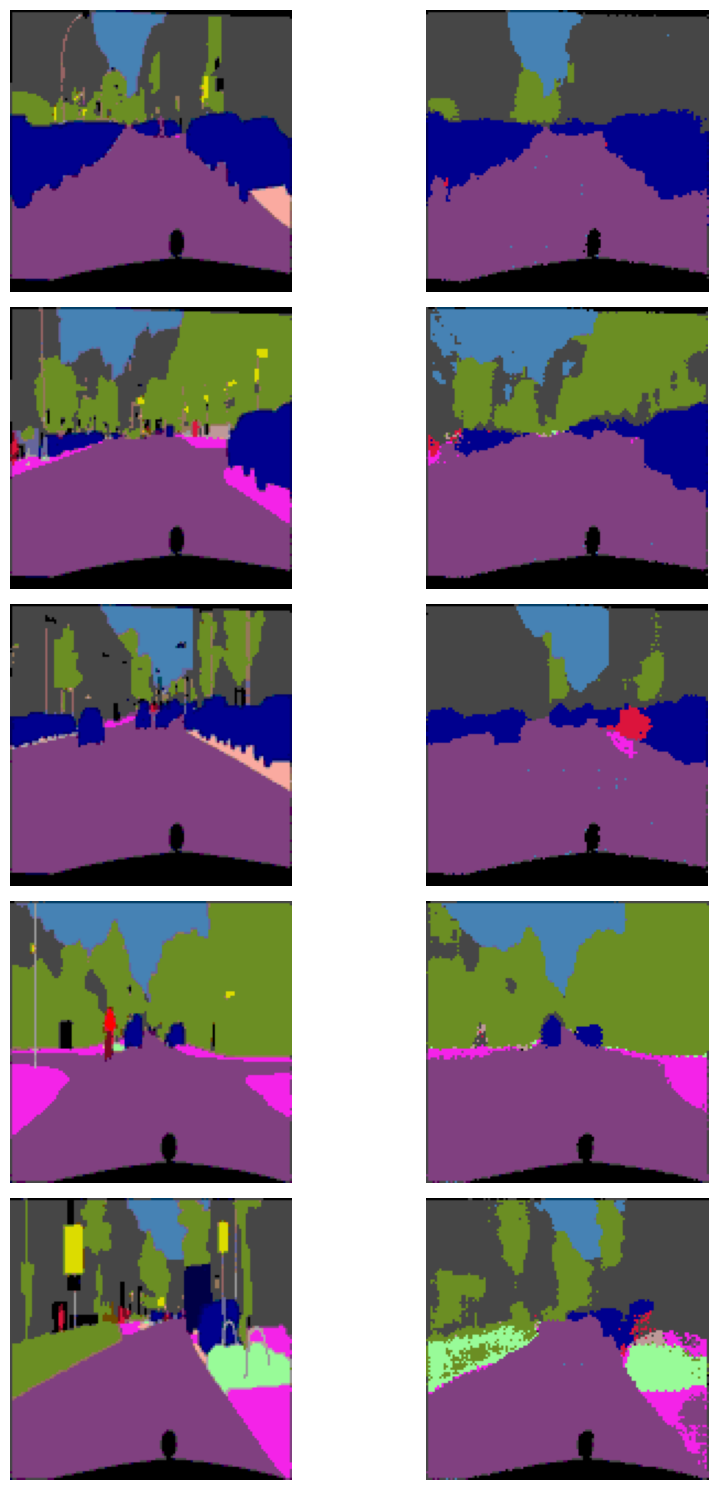

In [36]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for index, (true_mask, prediction) in enumerate(zip(true_masks, predictions)):

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[0], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[0]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 0].imshow(temp)
    axes[index, 0].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([prediction.shape[0], prediction.shape[0], 3], dtype='uint8')
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[0]):
            temp[row, col, :] = id_to_color[prediction[row, col]]

    axes[index, 1].imshow(temp)
    axes[index, 1].axis('off')

plt.tight_layout()
plt.show()

